In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    precision_score, recall_score, f1_score,
    roc_auc_score, average_precision_score,
    confusion_matrix, roc_curve, precision_recall_curve,
    classification_report
)

sns.set(style="whitegrid")
plt.rcParams["figure.figsize"] = (8,5)

# Load provider-level dataset (same file used in Notebook 02)
df = pd.read_csv("data/Provider_Level_Features.csv")
df.head()


,Provider,TotalReimbursement,AvgReimbursement,StdReimbursement,MaxReimbursement,MinReimbursement,TotalDeductible,AvgDeductible,TotalClaims,UniquePatients,...,ChronicCond_rheumatoidarthritis_Prevalence,ChronicCond_stroke_Prevalence,RenalDiseaseIndicator_Prevalence,InpatientRatio,ClaimsPerPatient,ReimbursementPerPatient,ReimbursementPerClaim,OutpatientRatio,PotentialFraud,PotentialFraud_Binary
0,PRV51001,104640,4185.600000,10796.091144,42000,10,5340,213.600000,25,24,...,0.320000,0.240000,0.320000,0.200000,1.041667,4360.000000,4185.600000,0.800000,No,0
1,PRV51003,605670,4588.409091,7309.794729,57000,0,66286,502.166667,132,117,...,0.287879,0.090909,0.219697,0.469697,1.128205,5176.666667,4588.409091,0.530303,Yes,1
2,PRV51004,52170,350.134228,689.963754,3300,0,310,2.080537,149,138,...,0.308725,0.114094,0.154362,0.000000,1.079710,378.043478,350.134228,1.000000,No,0
3,PRV51005,280910,241.124464,491.556392,4080,0,3700,3.175966,1165,495,...,0.284120,0.106438,0.222318,0.000000,2.353535,567.494949,241.124464,1.000000,Yes,1
4,PRV51007,33710,468.194444,1433.769116,10000,0,3264,45.333333,72,58,...,0.305556,0.166667,0.152778,0.041667,1.241379,581.206897,468.194444,0.958333,No,0


In [2]:
# Target selection
if "PotentialFraud_Binary" in df.columns:
    y = df["PotentialFraud_Binary"]
else:
    y = df["PotentialFraud"].map({"No": 0, "Yes": 1})

# Remove leakage columns
leak_cols = ["Provider", "PotentialFraud", "FraudLabel", "PotentialFraud_Binary"]
X = df.drop(columns=[c for c in leak_cols if c in df.columns])


In [3]:
# First: 80% train_temp + 20% test
X_train_temp, X_test, y_train_temp, y_test = train_test_split(
    X, y, test_size=0.20, stratify=y, random_state=42
)

# Second: 60% train + 20% val (i.e., 75%/25% of temp)
X_train, X_val, y_train, y_val = train_test_split(
    X_train_temp, y_train_temp, test_size=0.25, stratify=y_train_temp, random_state=42
)

print("Train size:", len(X_train))
print("Validation size:", len(X_val))
print("Test size:", len(X_test))


Train size: 3246
Validation size: 1082
Test size: 1082


### Why Logistic Regression Is Our Final Model

In Notebook 02, we compared multiple algorithms:

- Logistic Regression
- Random Forest
- Gradient Boosting
- Decision Tree
- SVM (optional)

Among all models, **Logistic Regression achieved the best performance on the 20% validation set**, especially in:

- Precision
- Recall
- F1-score
- PR-AUC (most important for imbalanced datasets)

Because it generalizes best, has the best validation performance, and maintains strong interpretability,
**Logistic Regression was selected as our final model for evaluation on the test set**.


In [4]:
# Class weights for balancing fraud vs non-fraud
model = LogisticRegression(
    max_iter=500,
    class_weight="balanced",
    solver="liblinear"
)

model.fit(X_train, y_train)
print("Logistic Regression model trained.")


Logistic Regression model trained.


In [5]:
y_pred = model.predict(X_test)
y_proba = model.predict_proba(X_test)[:, 1]

precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_proba)
pr_auc = average_precision_score(y_test, y_proba)

print("Classification Report:")
print(classification_report(y_test, y_pred, digits=4))

print("Precision:", precision)
print("Recall:", recall)
print("F1:", f1)
print("ROC-AUC:", roc_auc)
print("PR-AUC:", pr_auc)


Classification Report:
              precision    recall  f1-score   support

           0     0.9887    0.8930    0.9384       981
           1     0.4643    0.9010    0.6128       101

    accuracy                         0.8937      1082
   macro avg     0.7265    0.8970    0.7756      1082
weighted avg     0.9398    0.8937    0.9080      1082

Precision: 0.4642857142857143
Recall: 0.900990099009901
F1: 0.6127946127946128
ROC-AUC: 0.9681775517001242
PR-AUC: 0.7919414154154774


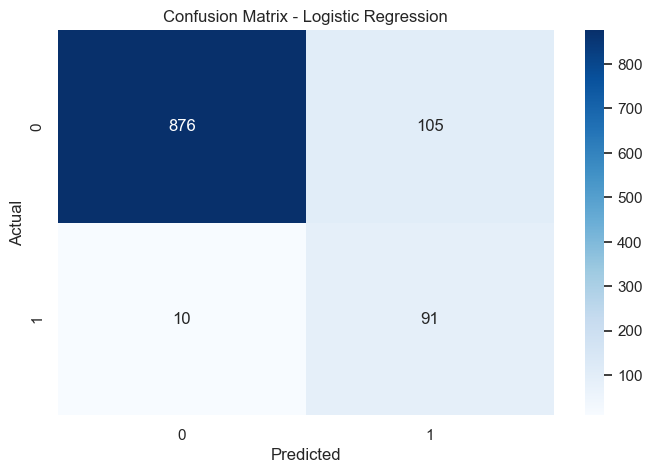

array([[876, 105],
       [ 10,  91]], dtype=int64)

In [6]:
cm = confusion_matrix(y_test, y_pred)

sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.title("Confusion Matrix - Logistic Regression")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

cm


### Cost-Based Interpretation

- **False Positives (FP)** = legitimate providers incorrectly flagged
  → leads to unnecessary investigations and administrative cost
- **False Negatives (FN)** = fraudulent providers missed
  → MOST EXPENSIVE: continuing fraud, financial loss, patient risk

Because FN are more harmful, **Recall** and **PR-AUC** matter more than Accuracy.

Logistic Regression gives a strong balance between detecting fraud (Recall) and minimizing false alarms (Precision).


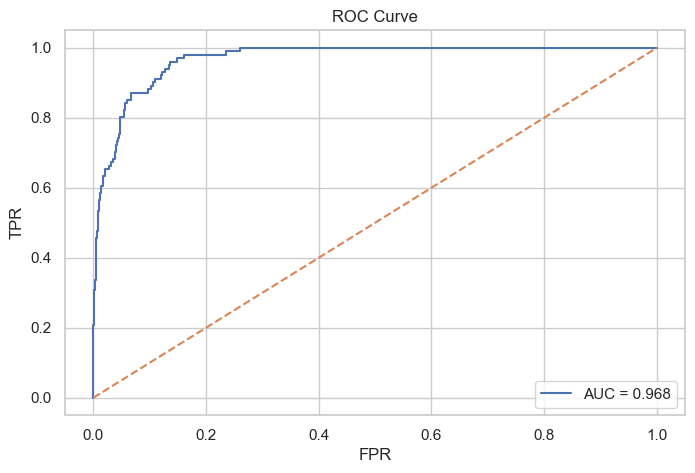

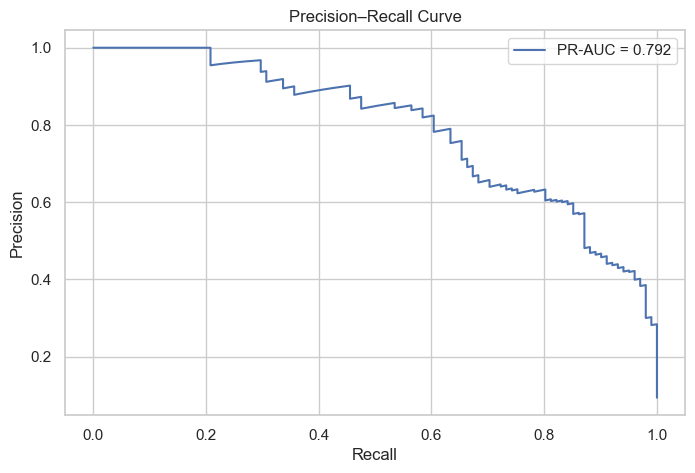

In [7]:
# ROC Curve & PR Curve
fpr, tpr, _ = roc_curve(y_test, y_proba)
plt.plot(fpr, tpr, label=f"AUC = {roc_auc:.3f}")
plt.plot([0,1], [0,1], linestyle="--")
plt.title("ROC Curve")
plt.xlabel("FPR")
plt.ylabel("TPR")
plt.legend()
plt.show()

# PR Curve
prec, rec, _ = precision_recall_curve(y_test, y_proba)
plt.plot(rec, prec, label=f"PR-AUC = {pr_auc:.3f}")
plt.title("Precision–Recall Curve")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.legend()
plt.show()


In [8]:
##False Positives & False Negatives
results = X_test.copy()
results["y_true"] = y_test.values
results["y_pred"] = y_pred
results["proba"] = y_proba

false_pos = results[(results.y_true == 0) & (results.y_pred == 1)]
false_neg = results[(results.y_true == 1) & (results.y_pred == 0)]

print("False Positives:", len(false_pos))
print("False Negatives:", len(false_neg))

false_pos.head(3), false_neg.head(3)


False Positives: 105
False Negatives: 10


(      TotalReimbursement  AvgReimbursement  StdReimbursement  \
 4648              220900       8836.000000      10833.469743   
 3723              233000       8321.428571       5333.705344   
 3876              416040       1762.881356       7864.944046   
 
       MaxReimbursement  MinReimbursement  TotalDeductible  AvgDeductible  \
 4648             57000                 0            25632    1025.280000   
 3723             25000              2000            29904    1068.000000   
 3876             87000                 0            19624      83.152542   
 
       TotalClaims  UniquePatients     AvgAge  ...  \
 4648           25              23  85.320000  ...   
 3723           28              27  80.500000  ...   
 3876          236             153  78.385593  ...   
 
       ChronicCond_stroke_Prevalence  RenalDiseaseIndicator_Prevalence  \
 4648                       0.160000                          0.080000   
 3723                       0.178571                          

### Error Analysis Summary

#### False Positives
- These providers show high utilization or claim totals.
- They resemble fraud patterns but are legitimate.
- This suggests the model is sensitive to high-volume behavior.

#### False Negatives
- Some fraudulent providers appear statistically normal.
- Fraud probability is often close to the classification threshold.
- Model may need more temporal or behavioral features.

#### Improvements
- Add time-series features (sudden spikes, inconsistent billing)
- Tune classification threshold based on PR curve
- Add interaction features or per-beneficiary ratios


### Preventing Overfitting

- Used **60/20/20 split** to avoid information leakage.
- Selected model based on **validation performance**, not test performance.
- Logistic Regression includes regularization (L2 by default).
- Used **class_weight="balanced"** to prevent majority-class overfitting.
- Compared validation vs. test metrics to ensure generalization.
